In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
pd.options.display.max_columns = None
pd.options.display.max_rows = None
matplotlib.rcParams.update({'font.size': 22})
from pytz import timezone as tz
import gluonts

In [2]:
data_path = "./data/"
data_freq = "H"
patience = 10
learning_rate = 0.0001

start_train_date = datetime(2017, 1, 1)
end_train_date = datetime(2018, 12, 31)
test_date = datetime(2019, 1, 1)
nb_hours_pred = 2*7*24

In [3]:
df = pd.read_csv(data_path + "eco2mix-regional-cons-def.csv", sep=";",
                parse_dates=["Date - Heure"],
                usecols=["Région", "Date - Heure", "Consommation (MW)"]).sort_values(
    by=["Région", "Date - Heure"])

In [4]:
df.rename(columns={"Date - Heure": "Date"}, inplace=True)
df.fillna(df.dropna()["Consommation (MW)"].mean(), inplace=True)
df["date_heure"] = df["Date"].apply(lambda x: x + timedelta(minutes=x.minute))
df["date_heure"] = df["date_heure"].apply(lambda x: x.astimezone(tz("UTC")))
df["date_heure"] = df["date_heure"].apply(lambda x: x.fromtimestamp(x.timestamp()))
df.head(3)

Région                       Date  Consommation (MW)  \
1288256  Auvergne-Rhône-Alpes  2013-01-01 00:00:00+01:00        4528.493194   
1288257  Auvergne-Rhône-Alpes  2013-01-01 00:30:00+01:00        8173.000000   
116935   Auvergne-Rhône-Alpes  2013-01-01 01:00:00+01:00        7944.000000   

                 date_heure  
1288256 2013-01-01 00:00:00  
1288257 2013-01-01 01:00:00  
116935  2013-01-01 01:00:00

In [5]:
df_hour = df.groupby(["Région", "date_heure"], as_index=False).agg({"Consommation (MW)": np.sum})
df_hour.head(3)

Région          date_heure  Consommation (MW)
0  Auvergne-Rhône-Alpes 2013-01-01 00:00:00        4528.493194
1  Auvergne-Rhône-Alpes 2013-01-01 01:00:00       16117.000000
2  Auvergne-Rhône-Alpes 2013-01-01 02:00:00       15778.000000

In [6]:
df_dict = {}

for region in pd.unique(df_hour["Région"]):
    df_dict[region] = df_hour[df_hour["Région"]==region].copy().reset_index(drop=True)
    df_dict[region].index = df_dict[region]["date_heure"]
    df_dict[region] = df_dict[region].reindex(
        pd.date_range(start=df_hour["date_heure"].min(), end=df_hour["date_heure"].max(), freq=data_freq)).drop(
        ["date_heure", "Région"], axis=1)

# Fonctions pour entraînement DeepAR

In [13]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

def train_predictor(df_dict, end_train_date, regions_list, target_col, max_epochs, feat_dynamic_cols=None):
    estimator = DeepAREstimator(freq=data_freq, 
                                prediction_length=nb_hours_pred,
                                trainer=Trainer(epochs=max_epochs, learning_rate = learning_rate,
                                                learning_rate_decay_factor=0.01, patience=patience),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    if feat_dynamic_cols is not None:
        
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:end_train_date]
                                   for feat_dynamic_col in feat_dynamic_cols] 
             }
            for region in regions_list],
            freq = data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date]
             }
            for region in regions_list],
            freq = data_freq
        )

    predictor = estimator.train(training_data=training_data)
    
    return predictor


def make_predictions(predictor, df_dict, test_date, regions_list, target_col, num_eval_samples, feat_dynamic_cols=None):
    if feat_dynamic_cols is not None:
        test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:test_date + timedelta(hours=nb_hours_pred)]
                                   for feat_dynamic_col in feat_dynamic_cols]
             }
            for region in regions_list],
            freq = data_freq
            )
    else:
         test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             }
            for region in regions_list],
            freq = data_freq
            )

    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=num_eval_samples)
    
    return list(forecast_it), list(ts_it)


def plot_forecasts(df_dict, test_date, tss, forecasts, past_length, num_plots, figname):
    label_fontsize = 16
    for target, forecast in zip(tss, forecasts):
        ax = target[-past_length:].plot(figsize=(20, 8), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        
        results_mean = forecast.mean
        ground_truth = df_dict[forecast.item_id]["Consommation (MW)"][
            test_date + timedelta(hours=1):test_date + timedelta(hours=nb_hours_pred)].values
        MAPE = np.mean(np.apply_along_axis(abs, 0, (ground_truth - results_mean) / ground_truth))
        plt.title(forecast.item_id + " MAPE:{}%".format(str(round(100*MAPE, 1))))
        plt.ylabel("Consumption (MW)")
        plt.xlabel("")
        ax.set_xlim([test_date - timedelta(days=nb_hours_pred/24), test_date + timedelta(days=nb_hours_pred/24)])
        ax.set_ylim([12000, 28000])
        xticks = [test_date + timedelta(days=x) for x in [-11, -7, -3, 0, 4, 8, 12]]
        ax.set_xticks(xticks, minor=True)
        ax.set_xticklabels([datetime.strftime(date, "%Y-%m-%d") for date in xticks if date != test_date],
                           minor=True, fontsize=label_fontsize)
        ax.set_xticklabels(["", datetime.strftime(test_date, "%Y-%m-%d"), ""], minor=False,
                           fontsize=label_fontsize)
        yticks = np.arange(14000, 28000, step=2000)
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(x) for x in yticks], fontsize=label_fontsize)
        plt.savefig(figname)
        plt.show()
    
    return MAPE

# Test Île de France

In [8]:
idf_list = ["Ile-de-France"]

for i in range(0):
    for max_epochs in [100]:
        idf_predictor = train_predictor(df_dict, end_train_date, idf_list, max_epochs=max_epochs,
                                        target_col="Consommation (MW)", feat_dynamic_cols=None)
        
        matplotlib.rcParams.update({'font.size': 22})
        forecasts, tss = make_predictions(idf_predictor, df_dict, test_date, idf_list,
                                          target_col="Consommation (MW)")
        MAPE = plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1,
                       figname="./deepar_stability_study/figures/{}_epochs_trial_{}.png".format(max_epochs, i+1))
        
        result_df = pd.DataFrame.from_records([{"max_epochs": max_epochs, "MAPE": MAPE, "trial_nb": i+1}])
        
        try:
            existing_results = pd.read_csv("./deepar_stability_study/results.csv")
        except:
            existing_results = None
        
        final_results = pd.concat([existing_results, result_df])
        
        final_results.to_csv("./deepar_stability_study/results.csv", index=False)
        

# Test de la variabilité pour un même modèle

In [9]:
idf_list = ["Ile-de-France"]

idf_predictor = train_predictor(df_dict, end_train_date, idf_list, max_epochs=20,
                                target_col="Consommation (MW)", feat_dynamic_cols=None)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it, avg_epoch_loss=10.4]
INFO:root:Epoch[0] Elapsed time 60.129 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.352239
INFO:root:Epoch[1] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=9.46]
INFO:root:Epoch[1] Elapsed time 53.604 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.463650
INFO:root:Epoch[2] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it, avg_epoch_loss=9.05]
INFO:root:Epoch[2] Elapsed time 53.207 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.054532
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████████████████████████

num_eval_sample: 10, trial #0


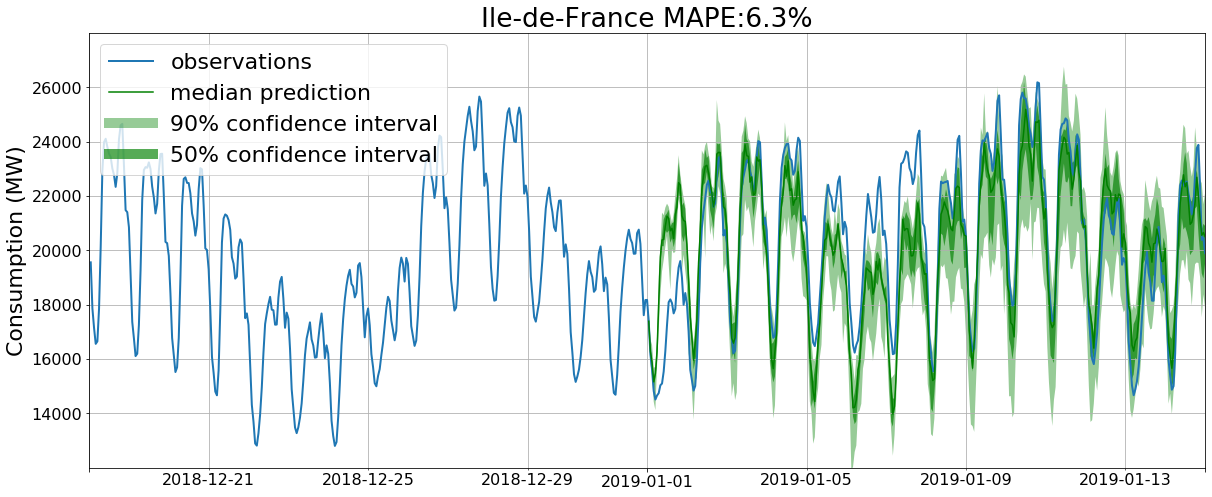

num_eval_sample: 10, trial #1


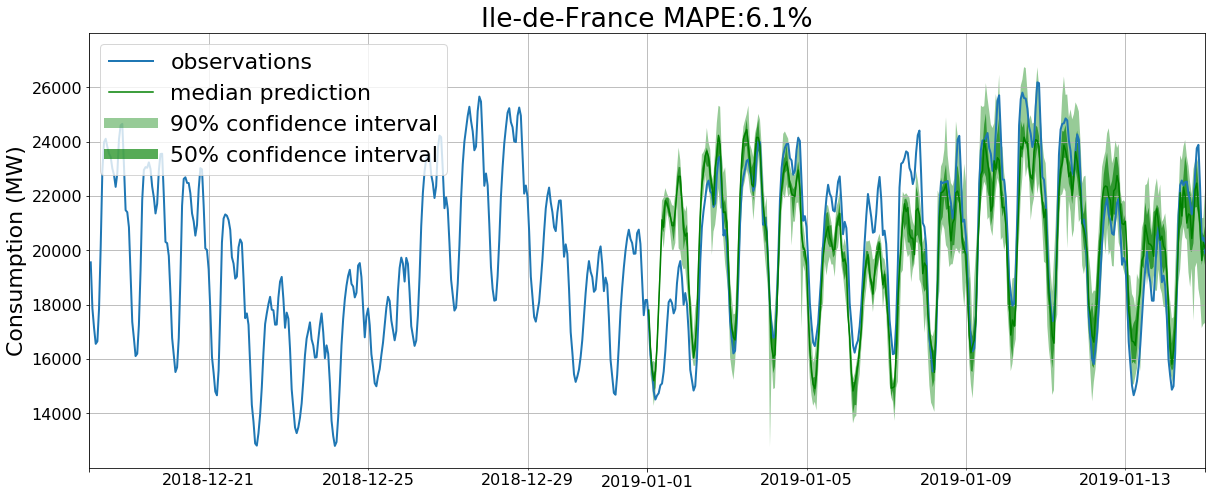

num_eval_sample: 10, trial #2


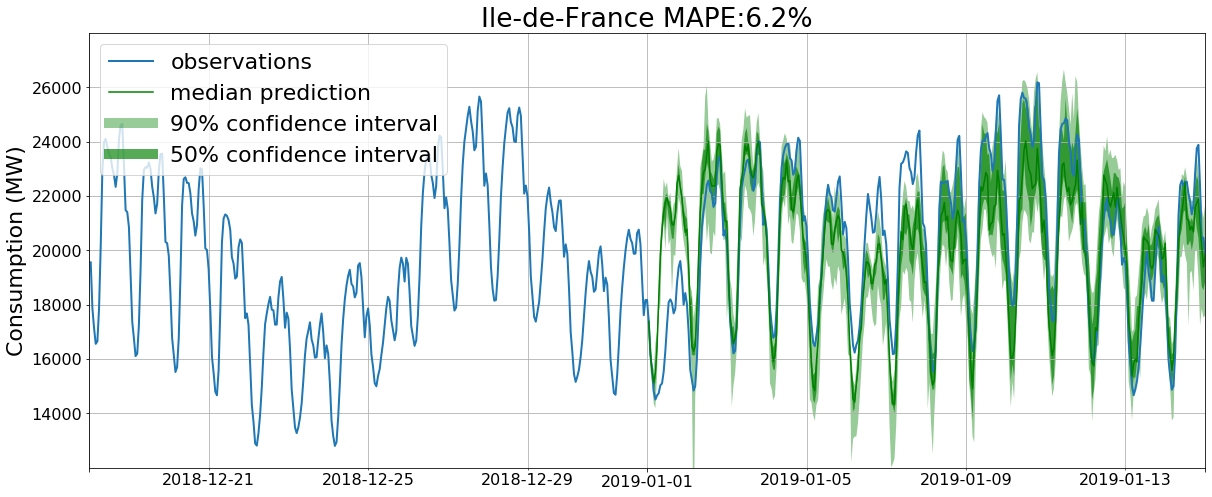

num_eval_sample: 10, trial #3


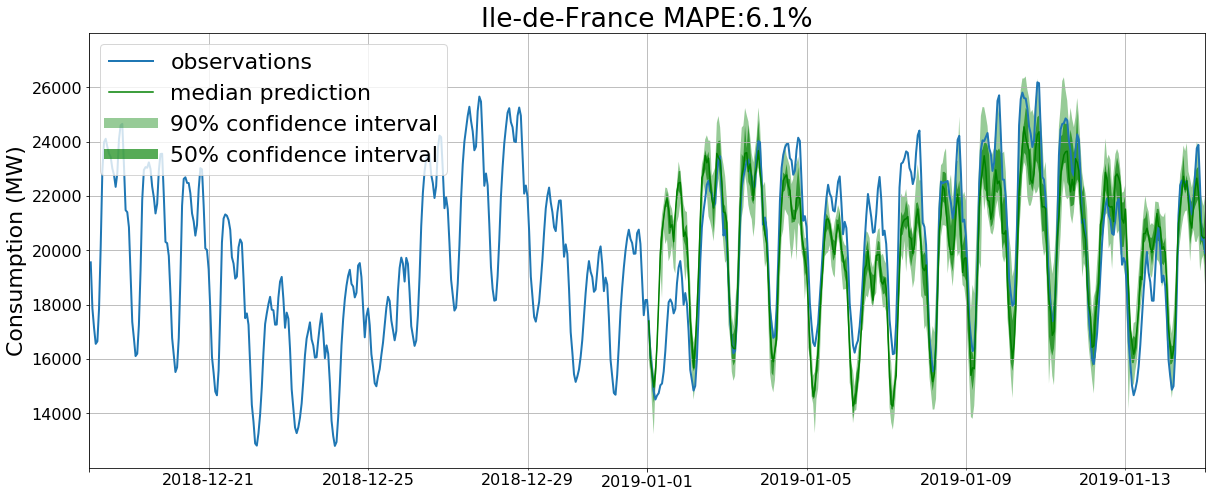

num_eval_sample: 10, trial #4


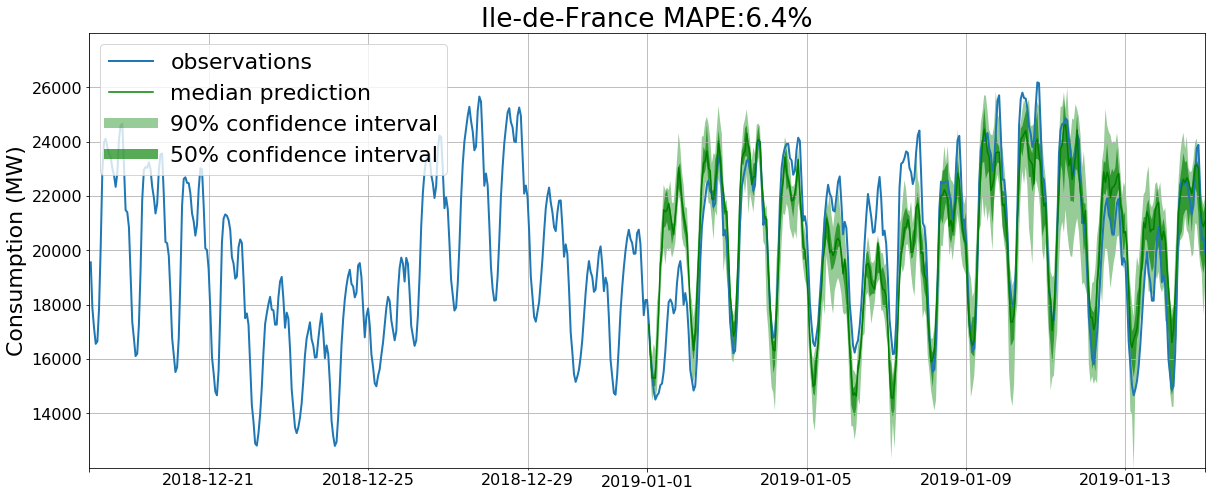

num_eval_sample: 10, trial #5


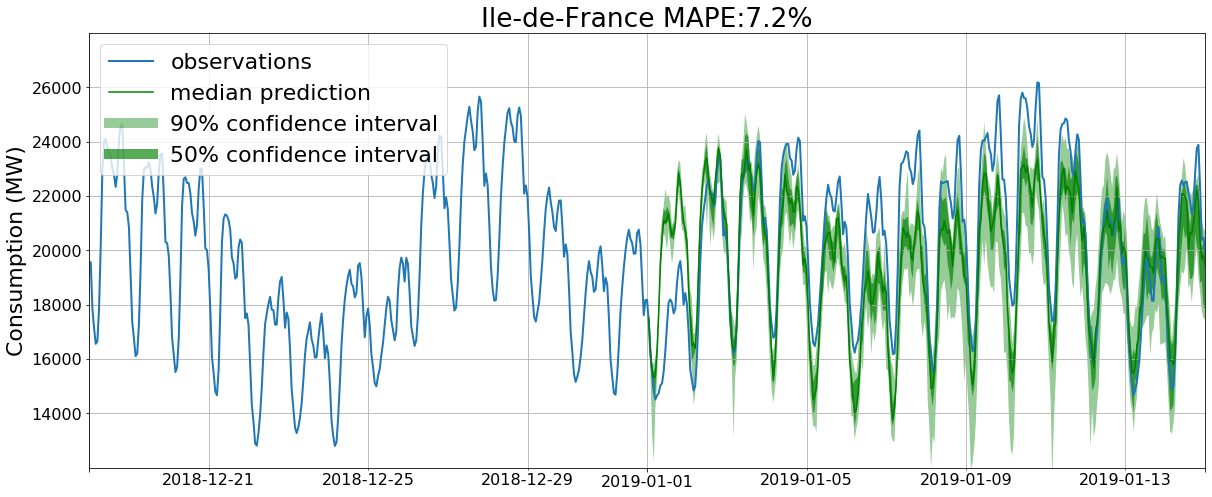

num_eval_sample: 10, trial #6


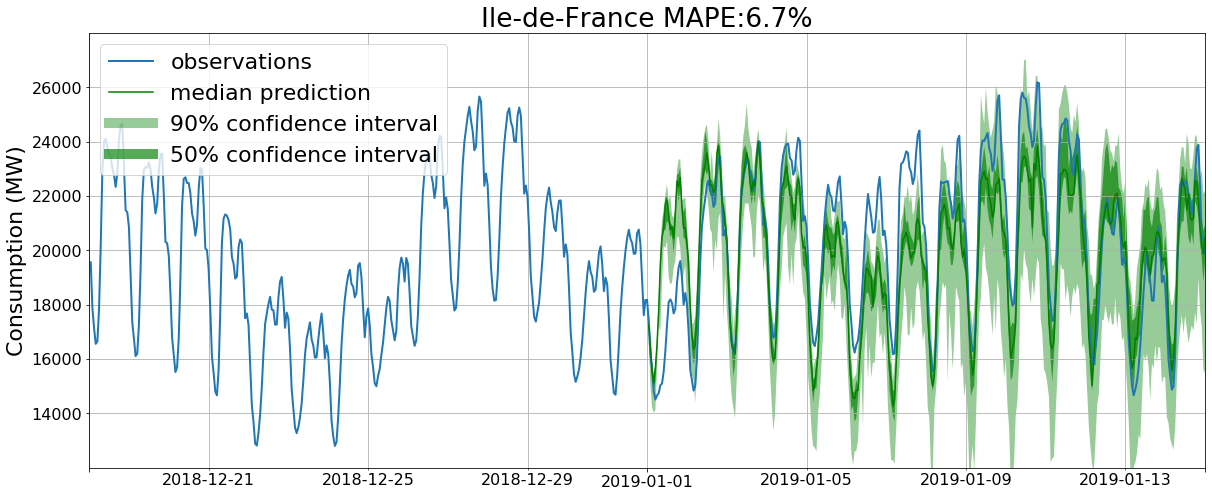

num_eval_sample: 10, trial #7


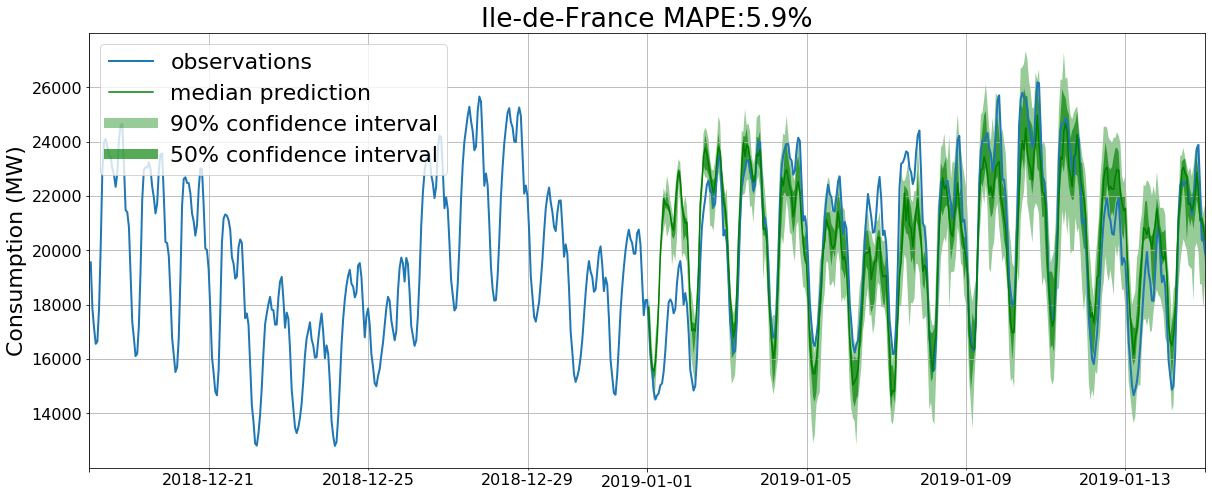

num_eval_sample: 10, trial #8


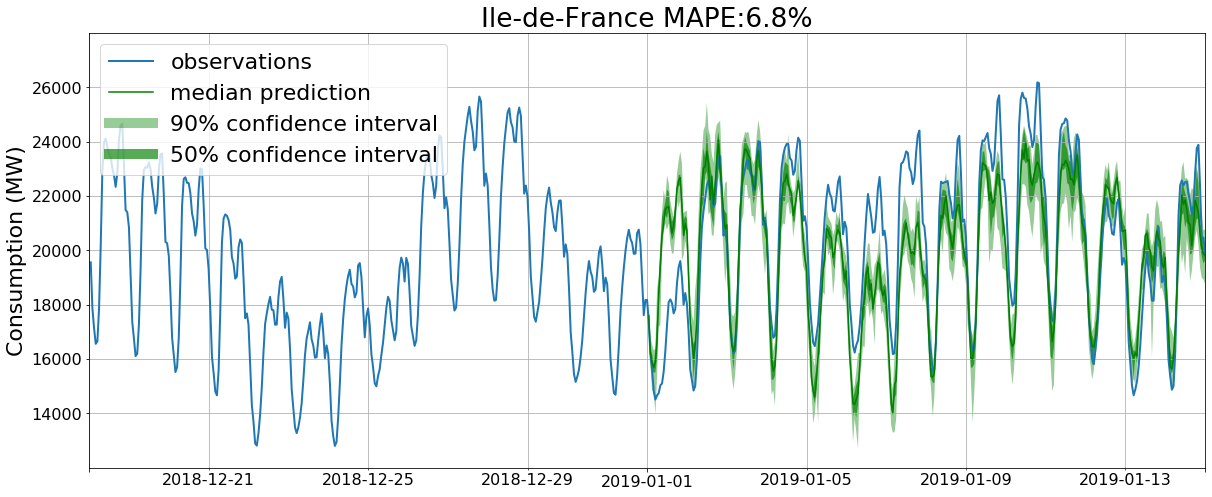

num_eval_sample: 10, trial #9


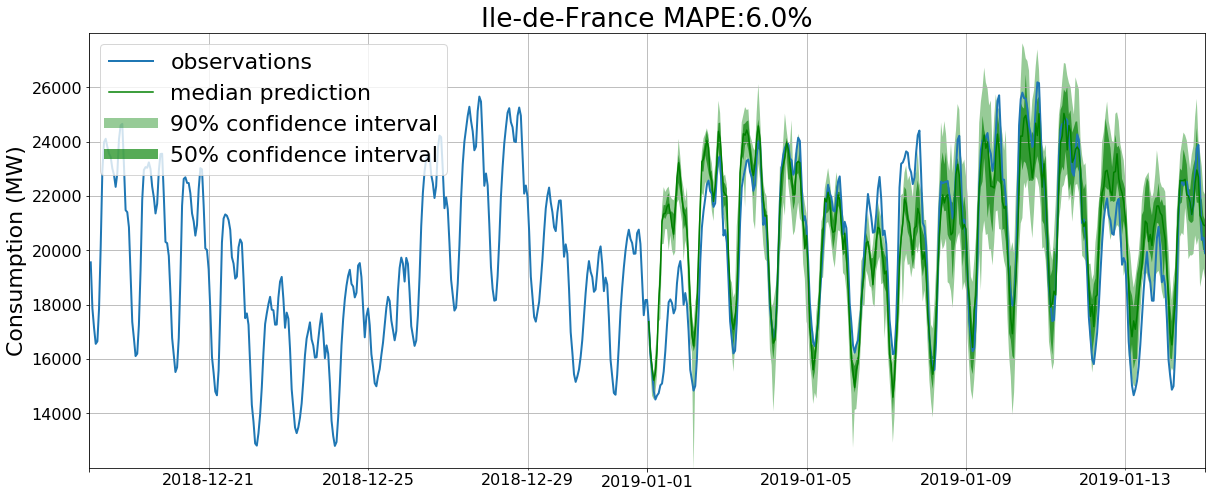

num_eval_sample: 100, trial #0


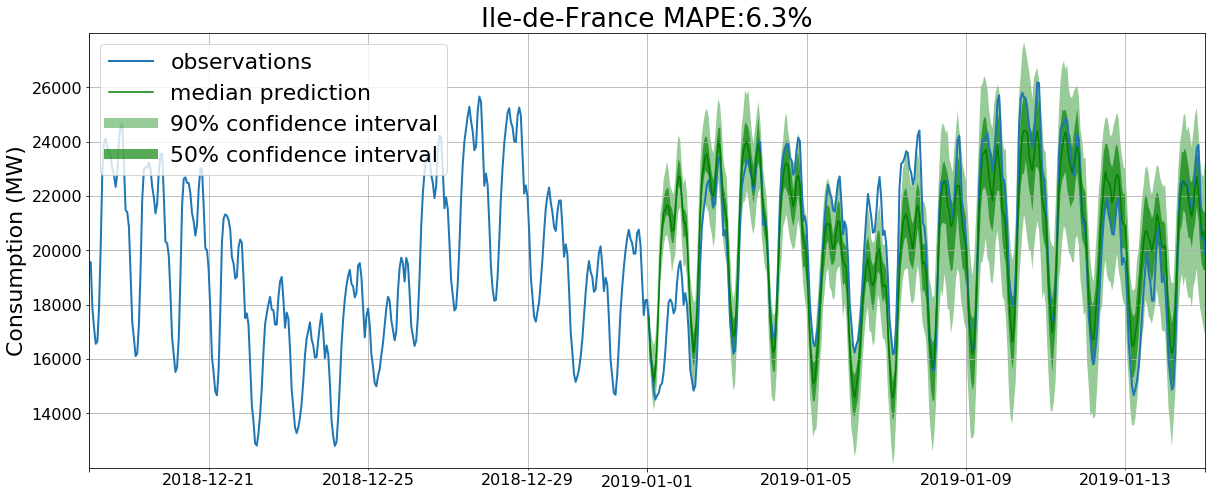

num_eval_sample: 100, trial #1


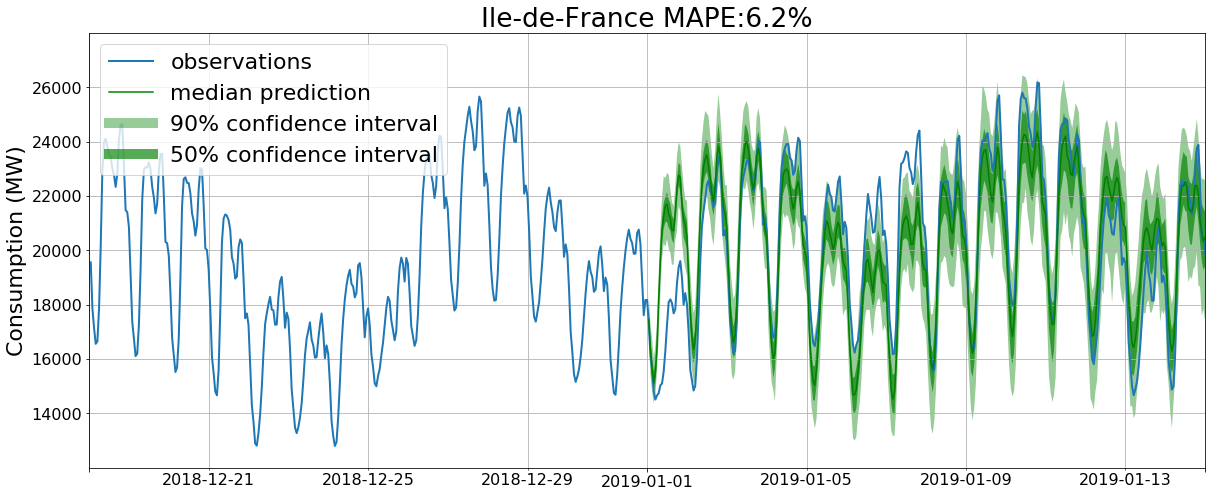

num_eval_sample: 100, trial #2


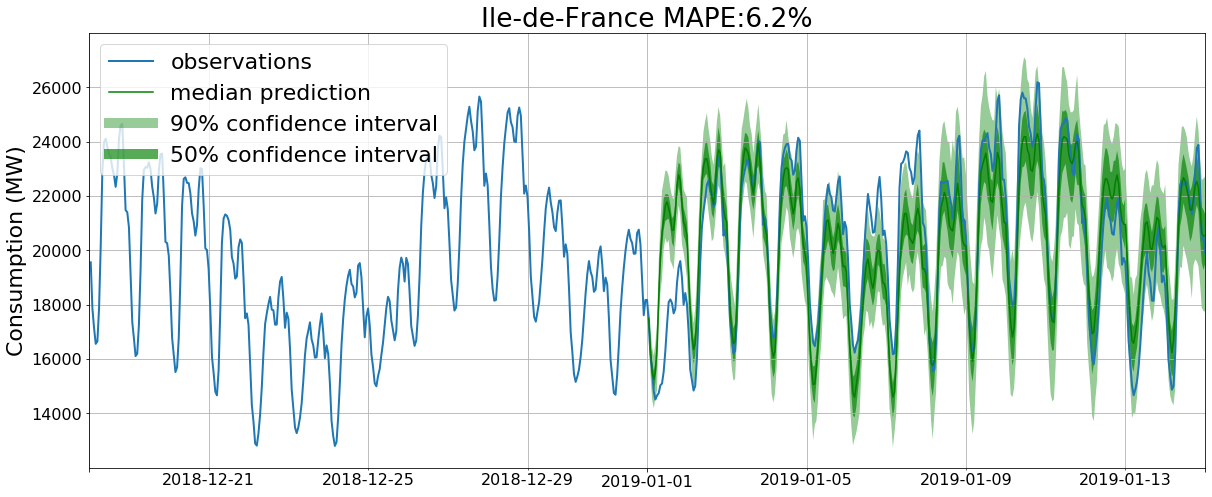

num_eval_sample: 100, trial #3


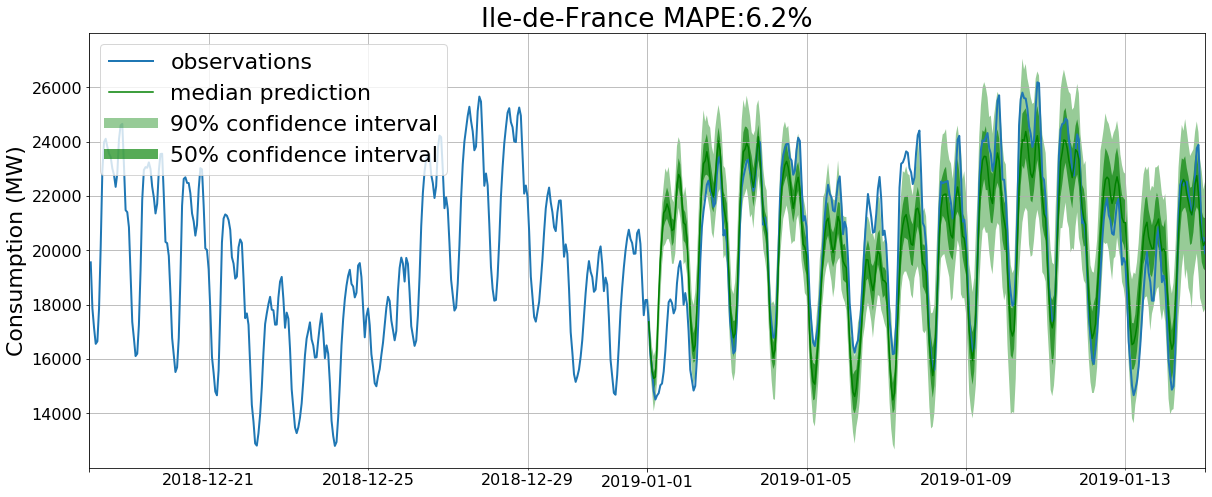

num_eval_sample: 100, trial #4


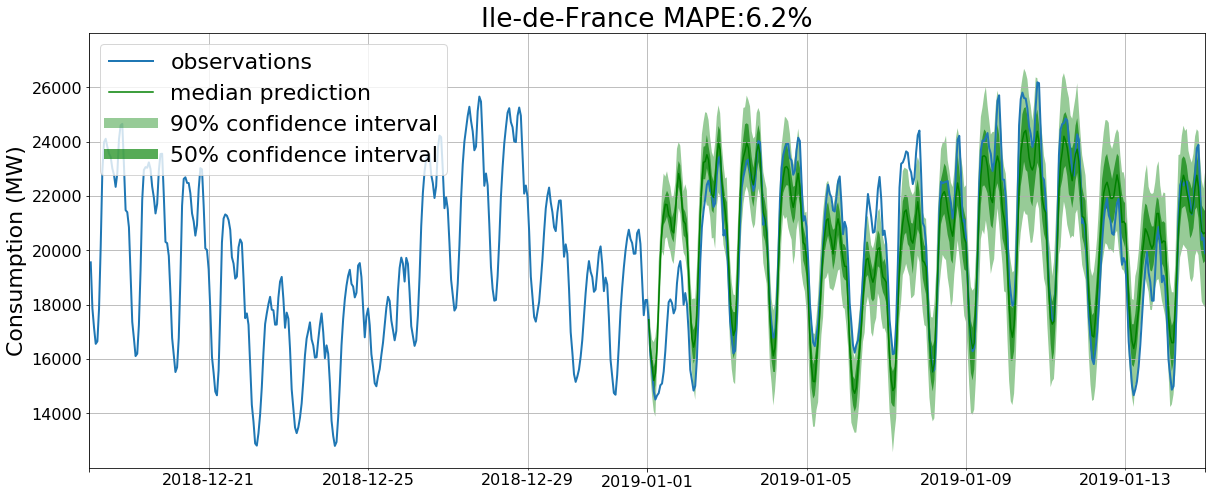

num_eval_sample: 100, trial #5


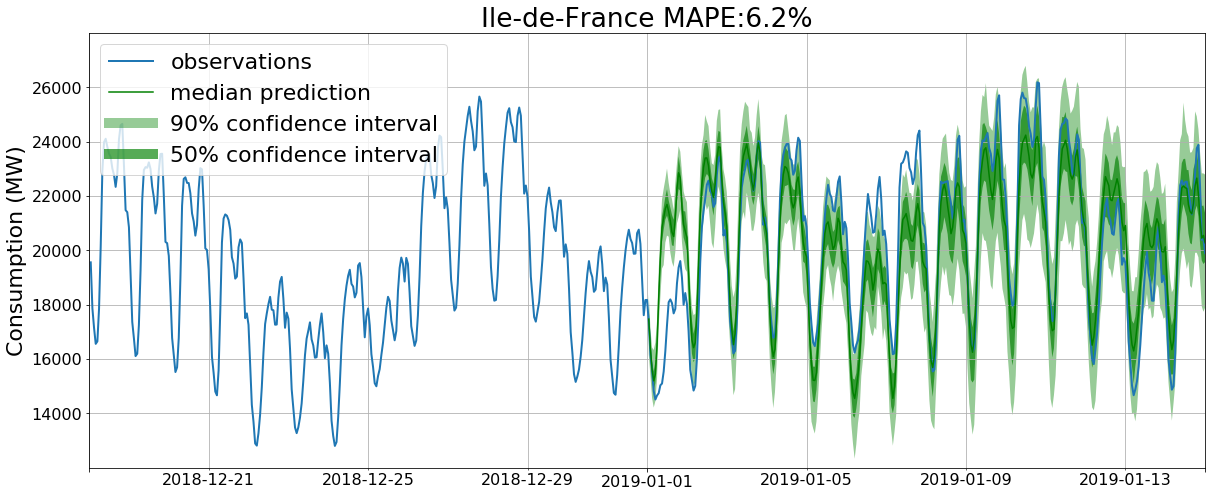

num_eval_sample: 100, trial #6


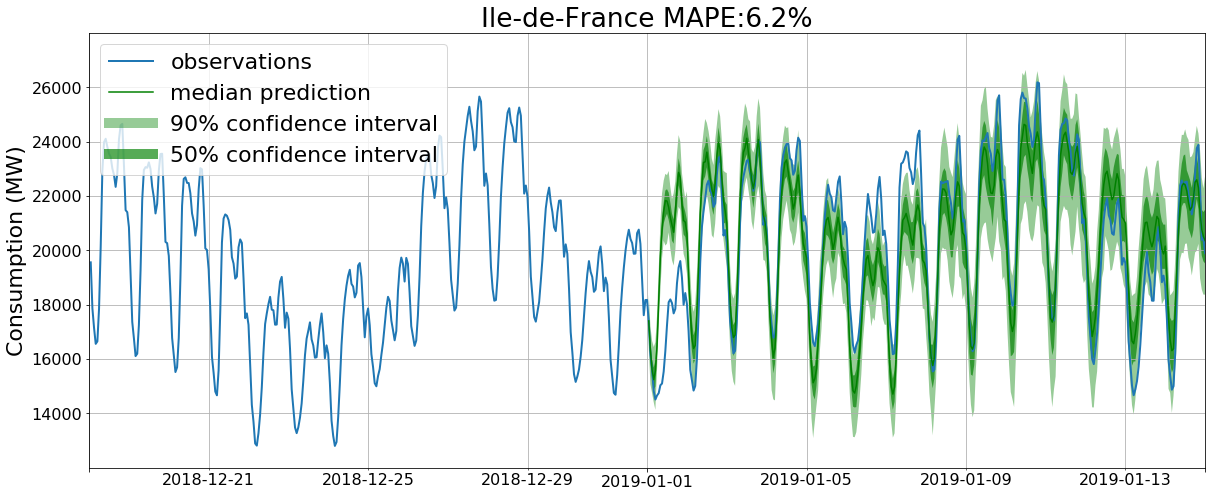

num_eval_sample: 100, trial #7


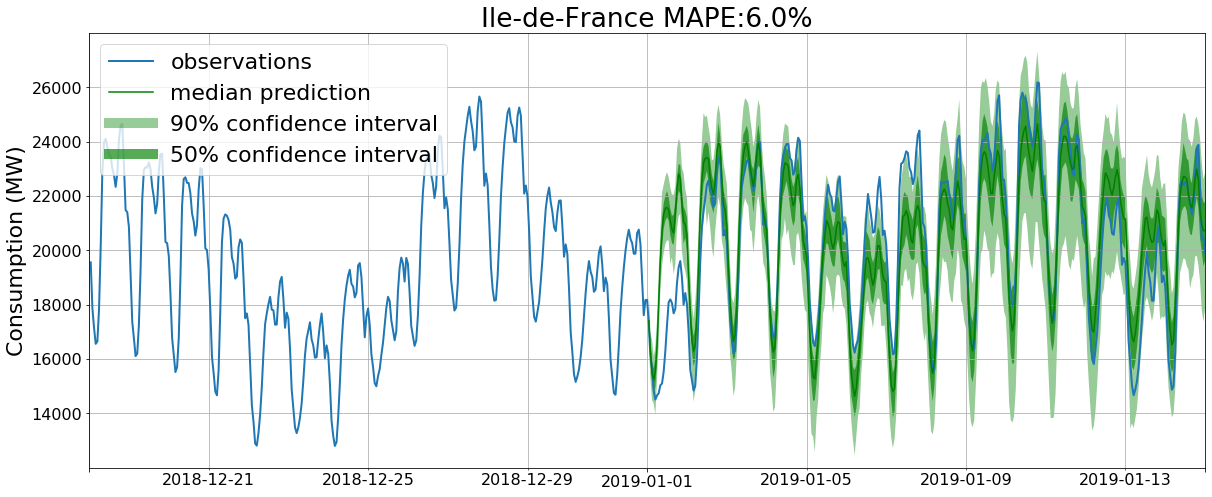

num_eval_sample: 100, trial #8


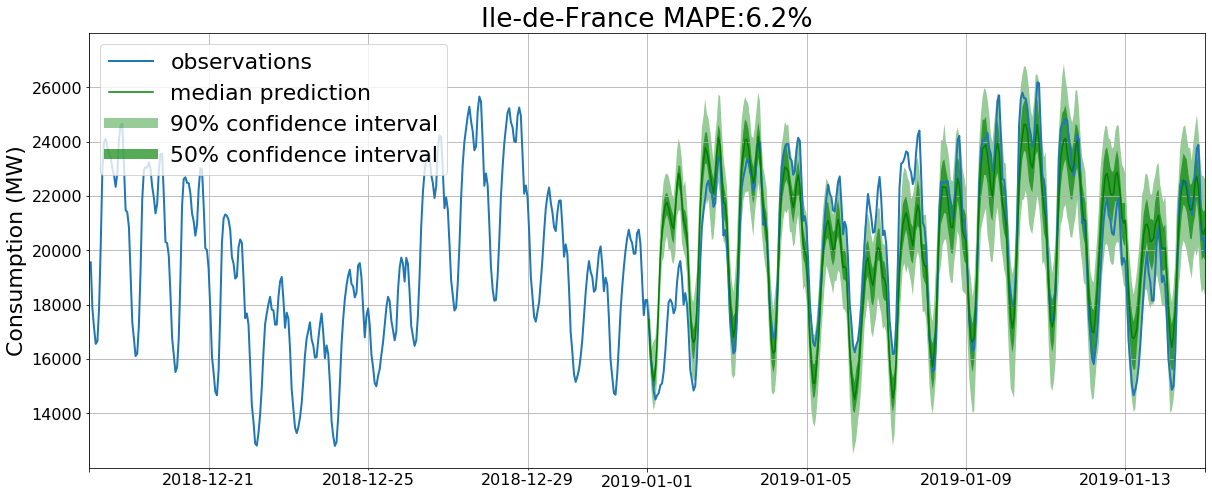

num_eval_sample: 100, trial #9


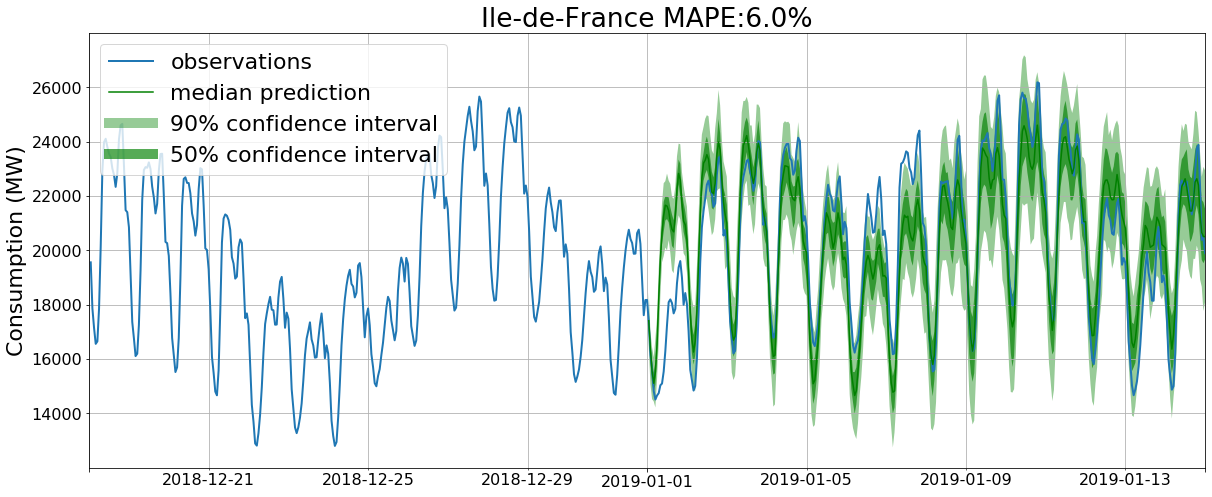

num_eval_sample: 1000, trial #0


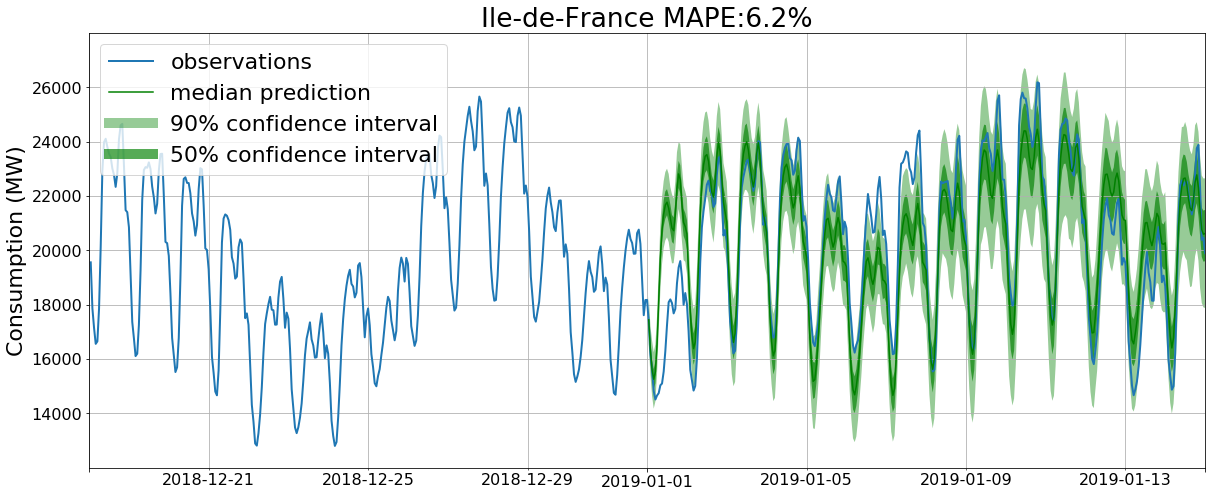

num_eval_sample: 1000, trial #1


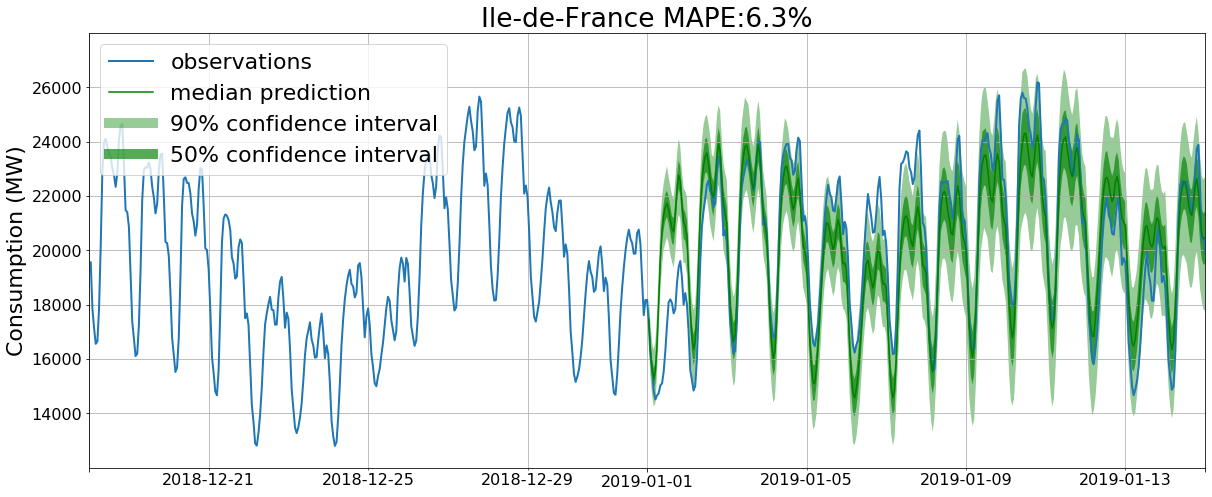

num_eval_sample: 1000, trial #2


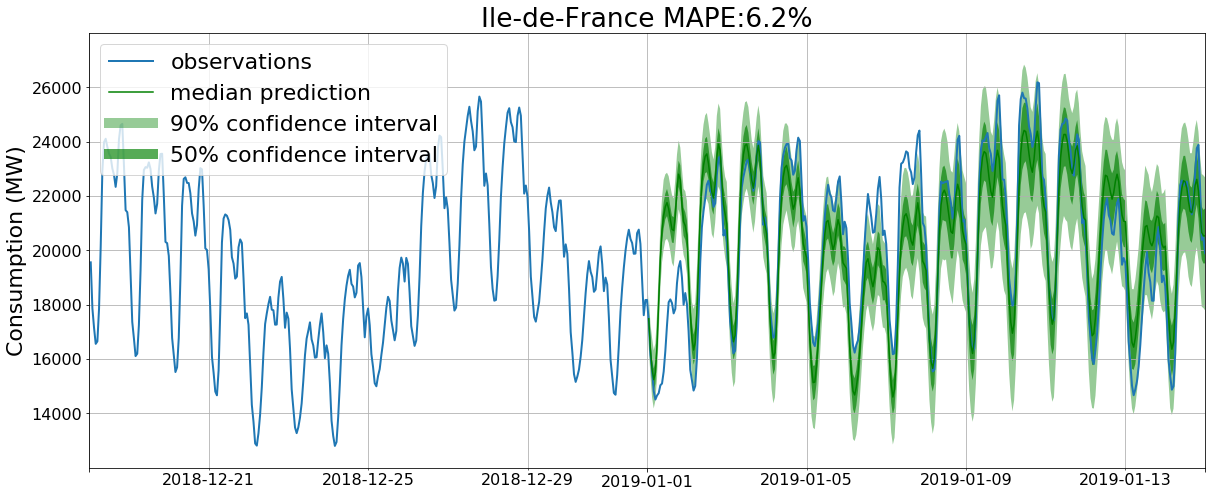

num_eval_sample: 1000, trial #3


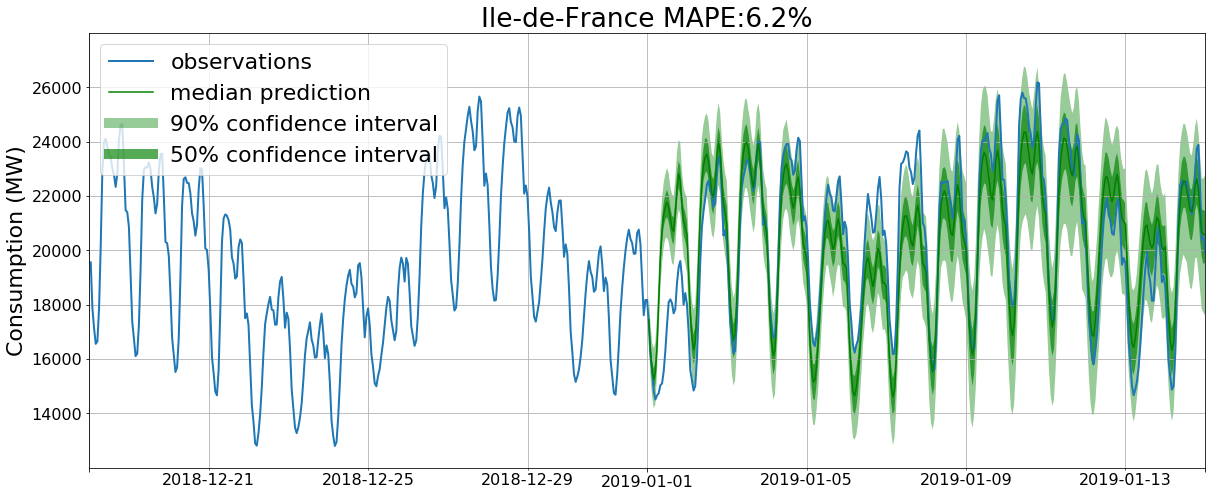

num_eval_sample: 1000, trial #4


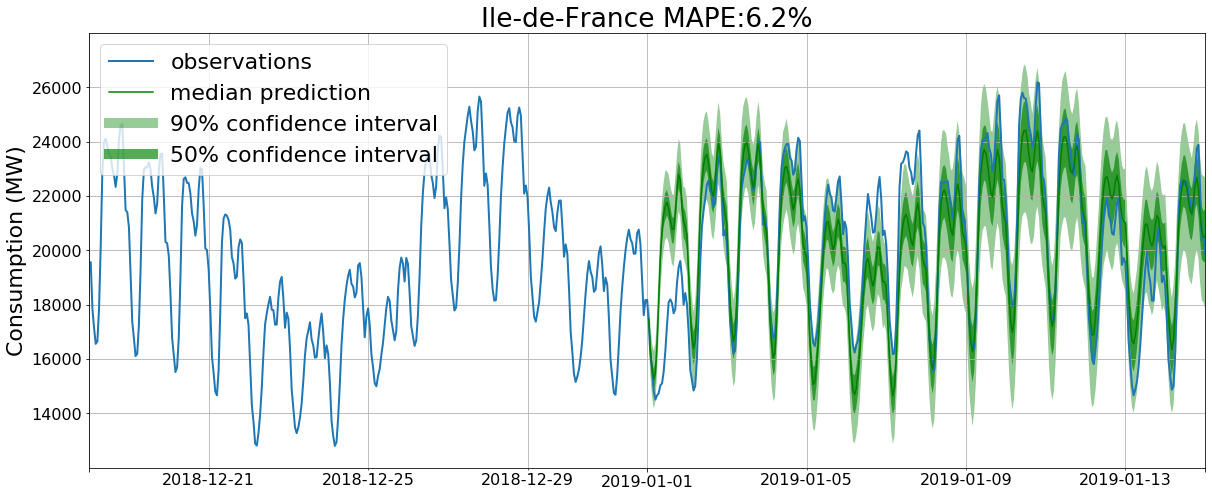

num_eval_sample: 1000, trial #5


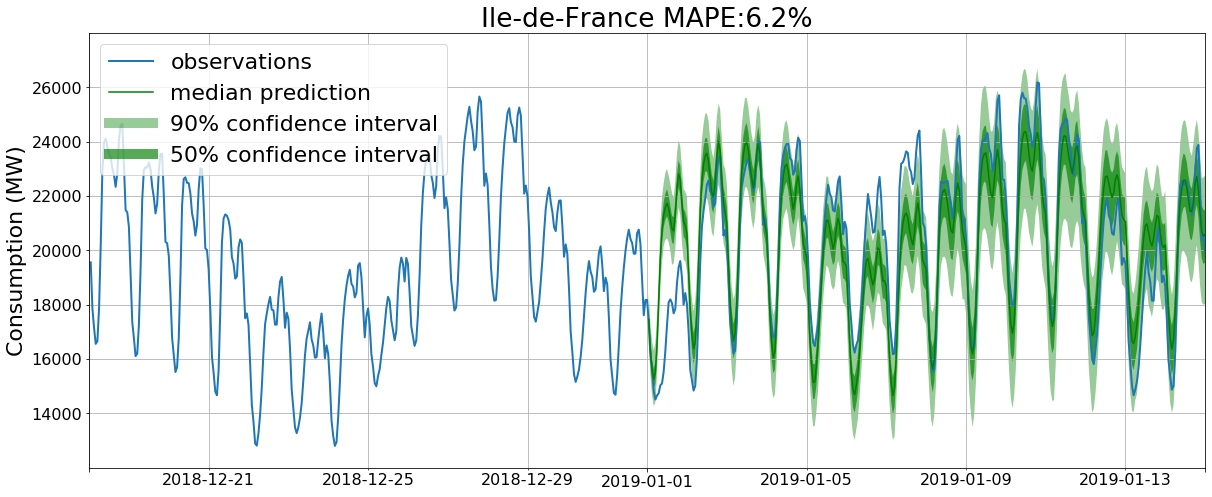

num_eval_sample: 1000, trial #6


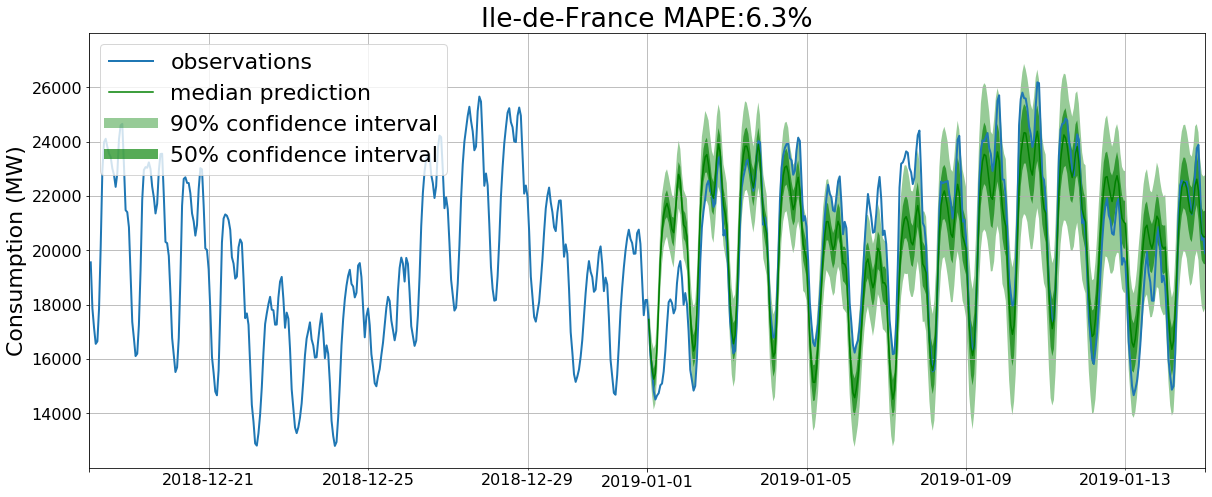

num_eval_sample: 1000, trial #7


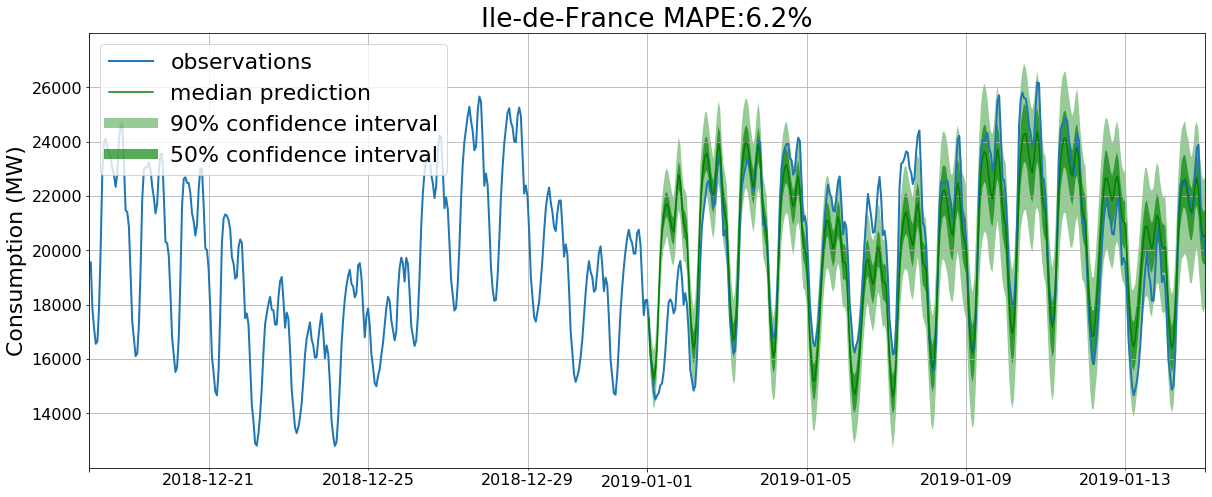

num_eval_sample: 1000, trial #8


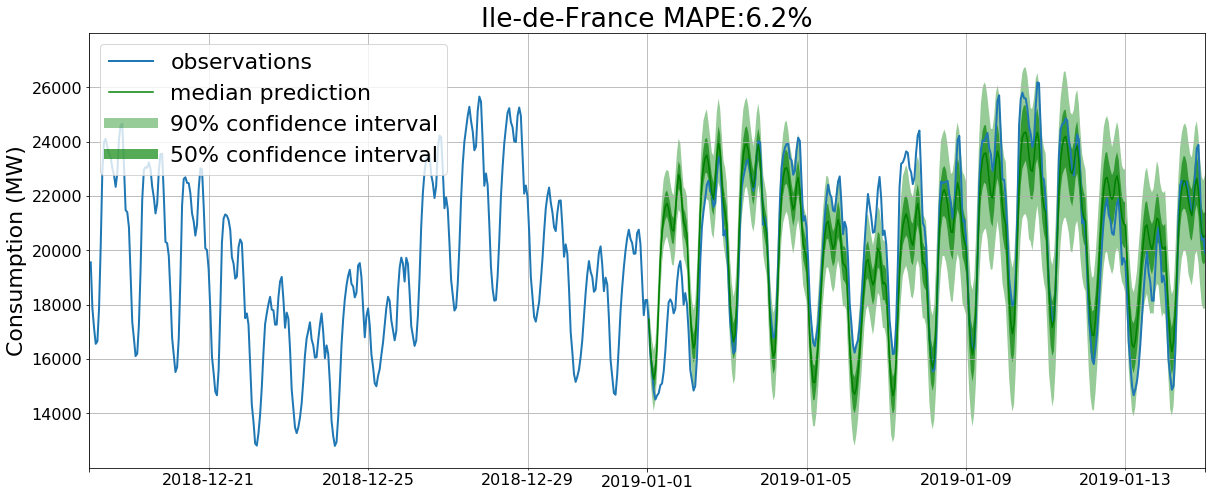

num_eval_sample: 1000, trial #9


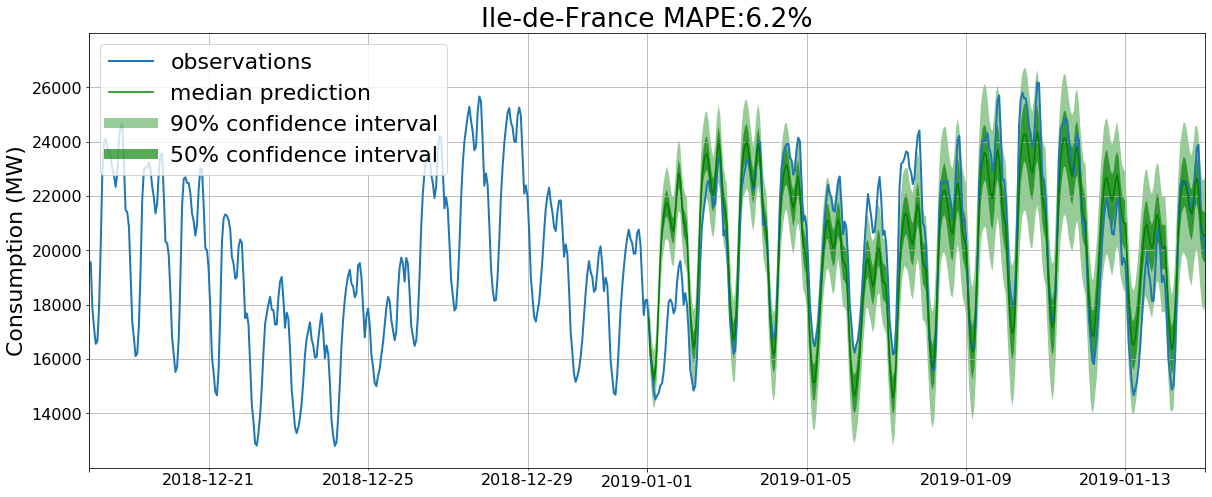

In [17]:
results_df_full = None

for num_eval_sample in [10, 100, 1000]:
    for i in range(10):
        print("num_eval_sample: {}, trial #{}".format(num_eval_sample, i))
        matplotlib.rcParams.update({'font.size': 22})
        forecasts, tss = make_predictions(idf_predictor, df_dict, test_date, idf_list,
                                          target_col="Consommation (MW)", num_eval_samples=num_eval_sample)
        MAPE = plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1,
                       figname="./deepar_stability_study/figures_modele_20_epochs/{}_samples_trial_{}.png".format(
                           num_eval_sample, i+1))
        
        results_df = pd.DataFrame.from_records([{"num_eval_sample": num_eval_sample, "MAPE": MAPE, "trial": i + 1}])
        
        results_df_full = pd.concat([results_df_full, results_df])
        
results_df_full.to_csv("./deepar_stability_study/sample_prediction_results.csv", index=False, sep=";")

In [18]:
results_df_full

num_eval_sample      MAPE  trial
0               10  0.062735      1
0               10  0.060558      2
0               10  0.062477      3
0               10  0.061097      4
0               10  0.063679      5
0               10  0.072038      6
0               10  0.066525      7
0               10  0.058707      8
0               10  0.068436      9
0               10  0.060380     10
0              100  0.062614      1
0              100  0.062153      2
0              100  0.062020      3
0              100  0.062220      4
0              100  0.062417      5
0              100  0.061608      6
0              100  0.061612      7
0              100  0.060404      8
0              100  0.061822      9
0              100  0.059725     10
0             1000  0.062046      1
0             1000  0.063076      2
0             1000  0.062183      3
0             1000  0.062200      4
0             1000  0.062325      5
0             1000  0.062188      6
0             1000  0.062608      7
0             1000  0.062192      8
0             1000  0.062176      9
0             1000  0.061978     10